### NOTES
- gen2_test_upto9_comp_final has the following ids that are not in the gen2_test_solution_template: [2636, 2656, 2785, 2794, 2808, 2812] 
- Not all ids in gen2_test_solution_template requires predictions from age 10 to 18

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings                               
warnings.filterwarnings('ignore')
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.model_selection import cross_val_score
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### Import data

In [2]:
test_gen1 = pd.read_csv('../final_proj/gen1_test_comp_final.csv')
test_gen2 = pd.read_csv('../final_proj/gen2_test_upto9_comp_final.csv')

In [3]:
train_gen1 = pd.read_csv('../final_proj/gen1_train_comp_final.csv')
train_gen2 = pd.read_csv('../final_proj/gen2_train_comp_final.csv')

### Pivot table

test data

In [4]:
# gen1 height
test_gen1_hgt_wide = test_gen1.pivot(index='gen1_id', columns='age', values='SHgt_cm')
test_gen1_hgt_wide.columns = [f'gen1_hgt_{col}' for col in test_gen1_hgt_wide.columns]
test_gen1_hgt_wide

,gen1_hgt_0.1,gen1_hgt_0.25,gen1_hgt_0.5,gen1_hgt_0.75,gen1_hgt_1.0,gen1_hgt_1.5,gen1_hgt_2.0,gen1_hgt_3.0,gen1_hgt_4.0,gen1_hgt_5.0,...,gen1_hgt_15.5,gen1_hgt_16.0,gen1_hgt_16.5,gen1_hgt_17.0,gen1_hgt_17.5,gen1_hgt_18.0,gen1_hgt_18.5,gen1_hgt_19.0,gen1_hgt_19.5,gen1_hgt_20.0
gen1_id,,,,,,,,,,,,,,,,,,,,,
368,56.354367,63.836912,71.932489,74.892811,78.896032,85.972432,90.808445,99.396320,NaN,112.246998,...,172.310016,174.161438,174.384112,175.541200,175.203908,175.302099,NaN,174.811082,NaN,174.913706
371,57.176447,63.845875,68.707965,73.620351,76.735173,83.271643,89.942236,99.792651,105.594557,113.604213,...,171.473101,172.241355,172.366107,172.284297,NaN,172.579514,NaN,172.139834,NaN,172.578356
389,51.875506,59.627795,66.082873,70.383861,73.057288,81.478045,85.740010,94.338745,100.768398,107.906615,...,NaN,155.406797,NaN,155.323388,NaN,155.269899,NaN,156.975310,NaN,157.471092
392,54.561466,61.438209,68.434611,74.891385,78.625815,82.381849,88.193138,99.793653,109.212759,115.427769,...,NaN,158.467215,NaN,157.700879,NaN,158.876322,NaN,159.047028,NaN,157.256242
404,57.283621,NaN,71.923391,73.932170,78.200101,85.125439,90.753847,101.782377,109.674187,115.422267,...,180.780412,184.064663,185.209428,186.092704,187.499119,188.793148,189.225005,189.836900,189.354337,191.193496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,54.592364,61.011232,69.645405,74.712002,78.775374,87.094661,91.281918,101.338595,110.315605,115.823750,...,181.795991,181.663882,181.777275,181.023549,NaN,181.926583,NaN,183.890546,NaN,182.333571
753,57.649214,62.705635,69.615657,73.130771,76.034858,83.401733,88.043315,96.548557,103.594390,113.619927,...,171.294249,171.944079,171.969244,171.143387,NaN,172.117627,NaN,173.239945,NaN,172.479134
763,52.628939,NaN,64.386757,66.297580,68.707505,74.509868,81.078680,91.818368,99.883638,105.858383,...,163.108696,163.689685,NaN,162.882193,NaN,162.868146,NaN,163.206896,NaN,163.207502


In [5]:
#gen1 gender
test_gen1_gender = test_gen1.groupby('gen1_id')[['sex_assigned_at_birth']].first()
test_gen1_gender.columns = ['gen1_gender']
test_gen1_gender

,gen1_gender
gen1_id,
368,M
371,F
389,F
392,F
404,M
...,...
748,M
753,F
763,F


In [6]:
# combine gen1 height and gender
test_gen1_wide = test_gen1_gender.join(test_gen1_hgt_wide)
test_gen1_wide.reset_index(inplace=True)
test_gen1_wide

,gen1_id,gen1_gender,gen1_hgt_0.1,gen1_hgt_0.25,gen1_hgt_0.5,gen1_hgt_0.75,gen1_hgt_1.0,gen1_hgt_1.5,gen1_hgt_2.0,gen1_hgt_3.0,...,gen1_hgt_15.5,gen1_hgt_16.0,gen1_hgt_16.5,gen1_hgt_17.0,gen1_hgt_17.5,gen1_hgt_18.0,gen1_hgt_18.5,gen1_hgt_19.0,gen1_hgt_19.5,gen1_hgt_20.0
0,368,M,56.354367,63.836912,71.932489,74.892811,78.896032,85.972432,90.808445,99.396320,...,172.310016,174.161438,174.384112,175.541200,175.203908,175.302099,NaN,174.811082,NaN,174.913706
1,371,F,57.176447,63.845875,68.707965,73.620351,76.735173,83.271643,89.942236,99.792651,...,171.473101,172.241355,172.366107,172.284297,NaN,172.579514,NaN,172.139834,NaN,172.578356
2,389,F,51.875506,59.627795,66.082873,70.383861,73.057288,81.478045,85.740010,94.338745,...,NaN,155.406797,NaN,155.323388,NaN,155.269899,NaN,156.975310,NaN,157.471092
3,392,F,54.561466,61.438209,68.434611,74.891385,78.625815,82.381849,88.193138,99.793653,...,NaN,158.467215,NaN,157.700879,NaN,158.876322,NaN,159.047028,NaN,157.256242
4,404,M,57.283621,NaN,71.923391,73.932170,78.200101,85.125439,90.753847,101.782377,...,180.780412,184.064663,185.209428,186.092704,187.499119,188.793148,189.225005,189.836900,189.354337,191.193496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,748,M,54.592364,61.011232,69.645405,74.712002,78.775374,87.094661,91.281918,101.338595,...,181.795991,181.663882,181.777275,181.023549,NaN,181.926583,NaN,183.890546,NaN,182.333571
58,753,F,57.649214,62.705635,69.615657,73.130771,76.034858,83.401733,88.043315,96.548557,...,171.294249,171.944079,171.969244,171.143387,NaN,172.117627,NaN,173.239945,NaN,172.479134
59,763,F,52.628939,NaN,64.386757,66.297580,68.707505,74.509868,81.078680,91.818368,...,163.108696,163.689685,NaN,162.882193,NaN,162.868146,NaN,163.206896,NaN,163.207502
60,764,F,54.241300,61.041457,69.262287,74.437856,76.823845,82.937267,87.599185,95.480005,...,164.218011,165.009965,166.154552,167.462405,165.987065,168.166121,168.146760,167.644255,NaN,167.243533


In [7]:
# gen2 height
test_gen2_hgt_wide = test_gen2.pivot(index='gen2_id', columns='AgeGr', values='SHgt_cm')
test_gen2_hgt_wide.columns = [f'gen2_hgt_{col}' for col in test_gen2_hgt_wide.columns]
test_gen2_hgt_wide

,gen2_hgt_0.1,gen2_hgt_0.25,gen2_hgt_0.5,gen2_hgt_0.75,gen2_hgt_1.0,gen2_hgt_1.5,gen2_hgt_2.0,gen2_hgt_3.0,gen2_hgt_4.0,gen2_hgt_5.0,gen2_hgt_6.0,gen2_hgt_7.0,gen2_hgt_8.0,gen2_hgt_9.0
gen2_id,,,,,,,,,,,,,,
2332,NaN,60.904589,65.427869,71.735214,74.239243,79.359604,82.108449,91.019129,97.413918,103.870670,109.936726,116.386523,120.052957,127.085434
2503,NaN,NaN,68.369395,72.218211,76.894700,NaN,89.375824,100.187839,108.233606,115.000674,122.531539,NaN,135.072529,NaN
2504,NaN,62.733051,67.185365,69.111514,74.700206,81.734484,86.669085,95.011010,102.629709,106.850400,112.435157,116.679299,123.692319,129.174593
2506,57.505810,NaN,70.448769,75.419846,78.648926,83.878779,92.439675,102.487697,109.749886,115.475808,121.629899,128.942749,134.341149,139.459044
2508,NaN,63.003795,69.965133,73.140370,77.159045,84.128667,88.858038,97.965989,107.352638,115.937959,124.002188,129.582019,137.364845,142.476229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2820,54.033054,60.508369,67.461502,71.665529,75.638018,82.669166,87.275235,97.117508,103.852288,110.436771,115.544696,118.959285,123.560549,129.789793
2821,52.541864,60.185721,67.452760,72.819855,76.296288,82.943933,87.745339,98.884833,108.813557,115.683180,122.141105,129.765068,136.435080,143.430368
2822,56.156864,62.950332,69.154497,73.938895,77.849343,86.161394,90.457748,100.286270,107.812102,114.336429,120.131471,126.165706,131.470996,137.026283


In [8]:
# gen2 weight
test_gen2_wgt_wide = test_gen2.pivot(index='gen2_id', columns='AgeGr', values='Wgt_kg')
test_gen2_wgt_wide.columns = [f'gen2_wgt_{col}' for col in test_gen2_wgt_wide.columns]
test_gen2_wgt_wide

,gen2_wgt_0.1,gen2_wgt_0.25,gen2_wgt_0.5,gen2_wgt_0.75,gen2_wgt_1.0,gen2_wgt_1.5,gen2_wgt_2.0,gen2_wgt_3.0,gen2_wgt_4.0,gen2_wgt_5.0,gen2_wgt_6.0,gen2_wgt_7.0,gen2_wgt_8.0,gen2_wgt_9.0
gen2_id,,,,,,,,,,,,,,
2332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.938306,22.661975,25.626890,26.943480,35.021449
2503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.733093,25.220951,NaN,32.075870,NaN
2504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.801185,21.608544,25.487586,28.165049,30.887921
2506,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.589161,24.378206,26.173383,30.090215,31.977254
2508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.894400,23.910967,26.714719,29.149901,32.631151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.883493,19.978860,20.329846,23.234800,26.969484
2821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.348459,26.223031,31.783233,37.214269,46.338635
2822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.251800,21.580247,23.799080,27.692860,30.309771


In [9]:
# gen2 parent
test_gen2_parent = test_gen2.groupby('gen2_id')[['study_parent_id_new']].first()
test_gen2_parent.columns = ['gen2_parent_id']
test_gen2_parent

,gen2_parent_id
gen2_id,
2332,274
2503,332
2504,623
2506,576
2508,333
...,...
2820,389
2821,600
2822,521


In [10]:
# gen2 gender
test_gen2_gender = test_gen2.groupby('gen2_id')[['sex_assigned_at_birth']].first()
test_gen2_gender.columns = ['gen2_gender']

In [11]:
# combine height, weight, parent, and gender for gen2
test_gen2_wide = test_gen2_gender.join([test_gen2_parent, test_gen2_hgt_wide, test_gen2_wgt_wide])
test_gen2_wide.reset_index(inplace=True)
test_gen2_wide

,gen2_id,gen2_gender,gen2_parent_id,gen2_hgt_0.1,gen2_hgt_0.25,gen2_hgt_0.5,gen2_hgt_0.75,gen2_hgt_1.0,gen2_hgt_1.5,gen2_hgt_2.0,...,gen2_wgt_1.0,gen2_wgt_1.5,gen2_wgt_2.0,gen2_wgt_3.0,gen2_wgt_4.0,gen2_wgt_5.0,gen2_wgt_6.0,gen2_wgt_7.0,gen2_wgt_8.0,gen2_wgt_9.0
0,2332,M,274,NaN,60.904589,65.427869,71.735214,74.239243,79.359604,82.108449,...,NaN,NaN,NaN,NaN,NaN,19.938306,22.661975,25.626890,26.943480,35.021449
1,2503,F,332,NaN,NaN,68.369395,72.218211,76.894700,NaN,89.375824,...,NaN,NaN,NaN,NaN,NaN,21.733093,25.220951,NaN,32.075870,NaN
2,2504,F,623,NaN,62.733051,67.185365,69.111514,74.700206,81.734484,86.669085,...,NaN,NaN,NaN,NaN,NaN,18.801185,21.608544,25.487586,28.165049,30.887921
3,2506,F,576,57.505810,NaN,70.448769,75.419846,78.648926,83.878779,92.439675,...,NaN,NaN,NaN,NaN,NaN,22.589161,24.378206,26.173383,30.090215,31.977254
4,2508,F,333,NaN,63.003795,69.965133,73.140370,77.159045,84.128667,88.858038,...,NaN,NaN,NaN,NaN,NaN,21.894400,23.910967,26.714719,29.149901,32.631151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,2820,M,389,54.033054,60.508369,67.461502,71.665529,75.638018,82.669166,87.275235,...,NaN,NaN,NaN,NaN,NaN,17.883493,19.978860,20.329846,23.234800,26.969484
84,2821,F,600,52.541864,60.185721,67.452760,72.819855,76.296288,82.943933,87.745339,...,NaN,NaN,NaN,NaN,NaN,20.348459,26.223031,31.783233,37.214269,46.338635
85,2822,M,521,56.156864,62.950332,69.154497,73.938895,77.849343,86.161394,90.457748,...,NaN,NaN,NaN,NaN,NaN,20.251800,21.580247,23.799080,27.692860,30.309771
86,2823,M,665,56.943083,62.762152,69.768578,75.458808,80.226826,86.198430,91.161540,...,NaN,NaN,NaN,NaN,NaN,18.712849,19.838448,22.812204,24.631916,26.320472


train data

In [12]:
# gen1 height
train_gen1_hgt_wide = train_gen1.pivot(index='gen1_id', columns='age', values='SHgt_cm')
train_gen1_hgt_wide.columns = [f'gen1_hgt_{col}' for col in train_gen1_hgt_wide.columns]
train_gen1_hgt_wide

,gen1_hgt_0.1,gen1_hgt_0.25,gen1_hgt_0.5,gen1_hgt_0.75,gen1_hgt_1.0,gen1_hgt_1.5,gen1_hgt_2.0,gen1_hgt_3.0,gen1_hgt_4.0,gen1_hgt_5.0,...,gen1_hgt_15.5,gen1_hgt_16.0,gen1_hgt_16.5,gen1_hgt_17.0,gen1_hgt_17.5,gen1_hgt_18.0,gen1_hgt_18.5,gen1_hgt_19.0,gen1_hgt_19.5,gen1_hgt_20.0
gen1_id,,,,,,,,,,,,,,,,,,,,,
370,56.040541,62.560859,70.338540,76.673608,78.063317,86.018694,92.239281,101.812521,110.926569,NaN,...,172.871774,173.087439,173.093158,173.680642,NaN,174.034011,NaN,174.233099,NaN,174.418909
371,57.418376,63.772686,69.596115,73.796708,76.127006,83.112889,88.707520,99.160057,106.209678,113.799244,...,171.450506,172.261825,172.379268,172.646257,NaN,172.200890,NaN,172.075126,NaN,173.100697
375,55.153190,63.371686,70.434241,74.452849,78.720473,84.513188,90.652232,105.983143,111.769232,118.303430,...,181.163703,182.084762,183.101623,184.756931,184.706826,185.558144,185.759924,185.864220,NaN,185.922876
376,54.528201,62.132331,68.238770,72.414316,75.119201,82.596449,88.046795,95.624714,102.118513,108.859461,...,170.828557,173.213424,174.765932,176.794776,178.219085,177.999918,178.414874,179.618422,179.373829,180.724155
377,58.371971,65.624997,73.877182,78.443835,83.473532,89.733324,97.713124,107.311409,113.037642,120.702038,...,189.379195,191.230623,191.842735,193.767378,194.113390,194.778597,194.873554,194.531218,NaN,194.928493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
753,57.599582,62.833016,70.135503,73.529001,76.724487,83.059931,87.936559,96.152698,104.638602,113.312875,...,172.560395,172.140141,172.045038,171.668174,NaN,172.220892,NaN,173.304073,NaN,172.525586
764,55.434207,61.706817,69.361629,74.509385,75.809629,83.692866,88.037658,95.832279,102.694795,109.731564,...,163.818125,165.256239,166.078422,166.070294,166.795975,167.316414,167.389489,167.826972,NaN,167.446567
768,54.340869,61.479216,69.732579,74.533590,77.560153,85.318934,93.359740,102.524584,112.477419,121.182592,...,175.310148,175.600643,NaN,175.045096,NaN,175.139273,NaN,175.409848,NaN,175.410151


In [13]:
# gen1 gender
train_gen1_gender = train_gen1.groupby('gen1_id')[['sex_assigned_at_birth']].first()
train_gen1_gender.columns = ['gen1_gender']

In [14]:
# combine gen1 height and gender
train_gen1_wide = train_gen1_gender.join(train_gen1_hgt_wide)
train_gen1_wide.reset_index(inplace=True)
train_gen1_wide 

,gen1_id,gen1_gender,gen1_hgt_0.1,gen1_hgt_0.25,gen1_hgt_0.5,gen1_hgt_0.75,gen1_hgt_1.0,gen1_hgt_1.5,gen1_hgt_2.0,gen1_hgt_3.0,...,gen1_hgt_15.5,gen1_hgt_16.0,gen1_hgt_16.5,gen1_hgt_17.0,gen1_hgt_17.5,gen1_hgt_18.0,gen1_hgt_18.5,gen1_hgt_19.0,gen1_hgt_19.5,gen1_hgt_20.0
0,370,F,56.040541,62.560859,70.338540,76.673608,78.063317,86.018694,92.239281,101.812521,...,172.871774,173.087439,173.093158,173.680642,NaN,174.034011,NaN,174.233099,NaN,174.418909
1,371,F,57.418376,63.772686,69.596115,73.796708,76.127006,83.112889,88.707520,99.160057,...,171.450506,172.261825,172.379268,172.646257,NaN,172.200890,NaN,172.075126,NaN,173.100697
2,375,M,55.153190,63.371686,70.434241,74.452849,78.720473,84.513188,90.652232,105.983143,...,181.163703,182.084762,183.101623,184.756931,184.706826,185.558144,185.759924,185.864220,NaN,185.922876
3,376,M,54.528201,62.132331,68.238770,72.414316,75.119201,82.596449,88.046795,95.624714,...,170.828557,173.213424,174.765932,176.794776,178.219085,177.999918,178.414874,179.618422,179.373829,180.724155
4,377,M,58.371971,65.624997,73.877182,78.443835,83.473532,89.733324,97.713124,107.311409,...,189.379195,191.230623,191.842735,193.767378,194.113390,194.778597,194.873554,194.531218,NaN,194.928493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,753,F,57.599582,62.833016,70.135503,73.529001,76.724487,83.059931,87.936559,96.152698,...,172.560395,172.140141,172.045038,171.668174,NaN,172.220892,NaN,173.304073,NaN,172.525586
97,764,F,55.434207,61.706817,69.361629,74.509385,75.809629,83.692866,88.037658,95.832279,...,163.818125,165.256239,166.078422,166.070294,166.795975,167.316414,167.389489,167.826972,NaN,167.446567
98,768,F,54.340869,61.479216,69.732579,74.533590,77.560153,85.318934,93.359740,102.524584,...,175.310148,175.600643,NaN,175.045096,NaN,175.139273,NaN,175.409848,NaN,175.410151
99,771,F,54.286850,60.267529,67.818744,NaN,76.861923,80.880033,86.803593,98.081002,...,161.696806,162.446983,162.614476,163.167202,NaN,163.063660,NaN,162.802728,NaN,162.602366


In [15]:
# gen2 height
train_gen2_hgt_wide = train_gen2.pivot(index='gen2_id', columns='AgeGr', values='SHgt_cm')
train_gen2_hgt_wide.columns = [f'gen2_hgt_{col}' for col in train_gen2_hgt_wide.columns]
train_gen2_hgt_wide

,gen2_hgt_0.1,gen2_hgt_0.25,gen2_hgt_0.5,gen2_hgt_0.75,gen2_hgt_1.0,gen2_hgt_1.5,gen2_hgt_2.0,gen2_hgt_3.0,gen2_hgt_4.0,gen2_hgt_5.0,...,gen2_hgt_8.0,gen2_hgt_9.0,gen2_hgt_10.0,gen2_hgt_11.0,gen2_hgt_12.0,gen2_hgt_13.0,gen2_hgt_14.0,gen2_hgt_15.0,gen2_hgt_16.0,gen2_hgt_18.0
gen2_id,,,,,,,,,,,,,,,,,,,,,
1332,54.098866,59.128432,67.256015,72.511388,74.886310,85.617761,91.007144,99.977795,109.291388,114.288786,...,135.387613,139.082846,145.262229,NaN,160.222405,NaN,NaN,NaN,NaN,NaN
2330,NaN,NaN,66.362172,69.582869,75.855070,80.153012,87.153373,93.533053,NaN,106.860775,...,121.884913,126.219288,131.799105,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2331,57.920127,NaN,70.718045,NaN,79.118851,NaN,89.661203,98.039558,103.095061,109.464829,...,129.665665,134.683255,141.524124,150.015631,161.792710,171.815312,NaN,NaN,NaN,NaN
2505,58.894508,62.822452,68.207623,72.622024,78.192172,85.216314,91.741224,100.252722,105.917235,111.278205,...,128.778979,133.779827,139.257516,144.366273,150.663565,NaN,NaN,NaN,NaN,NaN
2507,54.436597,61.947728,68.443083,72.281629,74.854322,83.284637,90.811808,101.297097,110.018713,117.068854,...,137.989206,144.463483,150.337479,156.747461,164.874826,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2825,54.033054,63.544369,71.610702,77.332729,81.406418,88.032766,93.448435,103.088308,109.620688,117.115971,...,135.400949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2827,54.059864,62.715721,69.375560,73.427055,76.093888,82.336733,86.024939,95.646433,103.449957,107.890780,...,125.809080,130.375568,137.226438,147.350383,NaN,155.343264,165.374217,170.255790,172.711099,174.151818
2829,50.388464,58.598732,66.118497,71.914895,75.420543,82.315794,87.624148,98.262270,104.978502,110.794429,...,129.750596,134.597483,141.468590,150.291349,160.823434,164.816989,166.242011,167.438765,168.077352,168.980405


In [16]:
# gen2 weight
train_gen2_wgt_wide = train_gen2.pivot(index='gen2_id', columns='AgeGr', values='Wgt_kg')
train_gen2_wgt_wide.columns = [f'gen2_wgt_{col}' for col in train_gen2_wgt_wide.columns]
train_gen2_wgt_wide

,gen2_wgt_0.1,gen2_wgt_0.25,gen2_wgt_0.5,gen2_wgt_0.75,gen2_wgt_1.0,gen2_wgt_1.5,gen2_wgt_2.0,gen2_wgt_3.0,gen2_wgt_4.0,gen2_wgt_5.0,...,gen2_wgt_8.0,gen2_wgt_9.0,gen2_wgt_10.0,gen2_wgt_11.0,gen2_wgt_12.0,gen2_wgt_13.0,gen2_wgt_14.0,gen2_wgt_15.0,gen2_wgt_16.0,gen2_wgt_18.0
gen2_id,,,,,,,,,,,,,,,,,,,,,
1332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.839206,...,28.566989,35.309511,41.387472,NaN,51.685399,NaN,NaN,NaN,NaN,NaN
2330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.204488,...,22.308756,25.653254,25.468107,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.465756,...,27.049411,30.743697,35.608657,40.234627,51.745533,59.709934,NaN,NaN,NaN,NaN
2505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.744253,...,27.762489,33.137320,32.355170,38.067498,42.536559,NaN,NaN,NaN,NaN,NaN
2507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.710666,...,30.970568,31.616559,37.311635,41.360412,47.850182,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.289783,...,28.366638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2827,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.741160,...,27.754112,30.471963,34.863497,33.167498,NaN,55.421246,63.470454,74.758524,84.170518,92.377751
2829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.981339,...,24.507504,27.064617,28.817890,38.449263,45.254956,51.549673,52.612519,55.580756,54.304768,55.014984


In [17]:
# gen2 parent
train_gen2_parent = train_gen2.groupby('gen2_id')[['study_parent_id_new']].first()
train_gen2_parent.columns = ['gen2_parent_id']
train_gen2_parent

,gen2_parent_id
gen2_id,
1332,724
2330,262
2331,274
2505,668
2507,350
...,...
2825,570
2827,744
2829,662


In [18]:
# gen2 gender
train_gen2_gender = train_gen2.groupby('gen2_id')[['sex_assigned_at_birth']].first()
train_gen2_gender.columns = ['gen2_gender']

In [19]:
# combine height, weight, parent, and gender for gen2
train_gen2_wide = train_gen2_gender.join([train_gen2_parent, train_gen2_hgt_wide, train_gen2_wgt_wide])
train_gen2_wide.reset_index(inplace=True)
train_gen2_wide 

,gen2_id,gen2_gender,gen2_parent_id,gen2_hgt_0.1,gen2_hgt_0.25,gen2_hgt_0.5,gen2_hgt_0.75,gen2_hgt_1.0,gen2_hgt_1.5,gen2_hgt_2.0,...,gen2_wgt_8.0,gen2_wgt_9.0,gen2_wgt_10.0,gen2_wgt_11.0,gen2_wgt_12.0,gen2_wgt_13.0,gen2_wgt_14.0,gen2_wgt_15.0,gen2_wgt_16.0,gen2_wgt_18.0
0,1332,F,724,54.098866,59.128432,67.256015,72.511388,74.886310,85.617761,91.007144,...,28.566989,35.309511,41.387472,NaN,51.685399,NaN,NaN,NaN,NaN,NaN
1,2330,F,262,NaN,NaN,66.362172,69.582869,75.855070,80.153012,87.153373,...,22.308756,25.653254,25.468107,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2331,M,274,57.920127,NaN,70.718045,NaN,79.118851,NaN,89.661203,...,27.049411,30.743697,35.608657,40.234627,51.745533,59.709934,NaN,NaN,NaN,NaN
3,2505,F,668,58.894508,62.822452,68.207623,72.622024,78.192172,85.216314,91.741224,...,27.762489,33.137320,32.355170,38.067498,42.536559,NaN,NaN,NaN,NaN,NaN
4,2507,F,350,54.436597,61.947728,68.443083,72.281629,74.854322,83.284637,90.811808,...,30.970568,31.616559,37.311635,41.360412,47.850182,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,2825,M,570,54.033054,63.544369,71.610702,77.332729,81.406418,88.032766,93.448435,...,28.366638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
188,2827,M,744,54.059864,62.715721,69.375560,73.427055,76.093888,82.336733,86.024939,...,27.754112,30.471963,34.863497,33.167498,NaN,55.421246,63.470454,74.758524,84.170518,92.377751
189,2829,F,662,50.388464,58.598732,66.118497,71.914895,75.420543,82.315794,87.624148,...,24.507504,27.064617,28.817890,38.449263,45.254956,51.549673,52.612519,55.580756,54.304768,55.014984
190,2830,F,712,55.222683,59.726152,66.428978,71.006008,76.178826,NaN,87.720740,...,32.425335,36.964074,42.717666,50.273574,58.372760,63.101934,60.983394,62.017302,66.225794,NaN


### Merge gen1 and gen2

In [20]:
# Outer join gen1 and gen2 to keep all gen1 and gen2 data
merged_test = pd.merge(test_gen1_wide, test_gen2_wide, left_on='gen1_id', right_on='gen2_parent_id', how='outer')
merged_test

,gen1_id,gen1_gender,gen1_hgt_0.1,gen1_hgt_0.25,gen1_hgt_0.5,gen1_hgt_0.75,gen1_hgt_1.0,gen1_hgt_1.5,gen1_hgt_2.0,gen1_hgt_3.0,...,gen2_wgt_1.0,gen2_wgt_1.5,gen2_wgt_2.0,gen2_wgt_3.0,gen2_wgt_4.0,gen2_wgt_5.0,gen2_wgt_6.0,gen2_wgt_7.0,gen2_wgt_8.0,gen2_wgt_9.0
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,19.938306,22.661975,25.626890,26.943480,35.021449
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,21.733093,25.220951,NaN,32.075870,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,21.894400,23.910967,26.714719,29.149901,32.631151
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,19.353711,22.762671,25.295461,26.442512,30.635631
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,17.794337,19.401765,21.071201,24.543731,27.149063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,753.0,F,57.649214,62.705635,69.615657,73.130771,76.034858,83.401733,88.043315,96.548557,...,NaN,NaN,NaN,NaN,NaN,16.825165,20.292258,21.875262,26.204071,28.599363
84,753.0,F,57.649214,62.705635,69.615657,73.130771,76.034858,83.401733,88.043315,96.548557,...,NaN,NaN,NaN,NaN,NaN,16.452651,20.029180,21.113550,24.627654,28.677749
85,763.0,F,52.628939,NaN,64.386757,66.297580,68.707505,74.509868,81.078680,91.818368,...,NaN,NaN,NaN,NaN,NaN,23.863886,27.041217,30.045160,35.055134,37.676966
86,764.0,F,54.241300,61.041457,69.262287,74.437856,76.823845,82.937267,87.599185,95.480005,...,NaN,NaN,NaN,NaN,NaN,17.868019,NaN,23.567309,25.384022,28.925162


In [21]:
merged_train = pd.merge(train_gen1_wide, train_gen2_wide, left_on='gen1_id', right_on='gen2_parent_id', how='outer')
merged_train

,gen1_id,gen1_gender,gen1_hgt_0.1,gen1_hgt_0.25,gen1_hgt_0.5,gen1_hgt_0.75,gen1_hgt_1.0,gen1_hgt_1.5,gen1_hgt_2.0,gen1_hgt_3.0,...,gen2_wgt_8.0,gen2_wgt_9.0,gen2_wgt_10.0,gen2_wgt_11.0,gen2_wgt_12.0,gen2_wgt_13.0,gen2_wgt_14.0,gen2_wgt_15.0,gen2_wgt_16.0,gen2_wgt_18.0
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22.308756,25.653254,25.468107,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27.049411,30.743697,35.608657,40.234627,51.745533,59.709934,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,29.499903,32.329625,36.528249,43.826346,52.475128,56.214051,54.452854,57.006305,59.626217,56.549063
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,34.057150,36.693161,44.821911,51.766981,63.949867,70.997049,76.107394,94.203882,100.032268,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,25.637883,27.203007,30.075198,33.611668,37.244876,42.327895,48.484170,51.766677,53.283990,54.975570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,771.0,F,54.286850,60.267529,67.818744,NaN,76.861923,80.880033,86.803593,98.081002,...,24.250090,27.103773,28.883228,32.185403,34.873323,39.017828,44.270893,50.912443,59.622400,NaN
188,771.0,F,54.286850,60.267529,67.818744,NaN,76.861923,80.880033,86.803593,98.081002,...,25.342496,28.502397,30.619110,32.867720,36.125384,38.706092,45.719652,51.347211,57.319569,62.834579
189,771.0,F,54.286850,60.267529,67.818744,NaN,76.861923,80.880033,86.803593,98.081002,...,25.635317,27.831912,30.441528,32.690829,35.888735,38.748603,42.643458,47.548405,55.764296,66.351083
190,774.0,F,56.961812,64.826190,74.340764,79.747338,84.092569,90.690032,96.994591,106.615702,...,26.695782,29.411600,33.362739,36.095260,40.614852,46.682671,52.226154,NaN,64.520850,72.749629


Here, gen1_gender has missing values because those gen2_id don't have corresponding parents

In [22]:
# these are the target variables we want to predict
Y_train = merged_train[['gen2_id', 'gen2_hgt_10.0',
  'gen2_hgt_11.0',
  'gen2_hgt_12.0',
  'gen2_hgt_13.0',
  'gen2_hgt_14.0',
  'gen2_hgt_15.0',
  'gen2_hgt_16.0',
  'gen2_hgt_18.0']]
Y_train.sort_values(by='gen2_id', inplace=True)
Y_train.set_index('gen2_id', inplace=True)
Y_train

,gen2_hgt_10.0,gen2_hgt_11.0,gen2_hgt_12.0,gen2_hgt_13.0,gen2_hgt_14.0,gen2_hgt_15.0,gen2_hgt_16.0,gen2_hgt_18.0
gen2_id,,,,,,,,
1332,145.262229,NaN,160.222405,NaN,NaN,NaN,NaN,NaN
2330,131.799105,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2331,141.524124,150.015631,161.792710,171.815312,NaN,NaN,NaN,NaN
2505,139.257516,144.366273,150.663565,NaN,NaN,NaN,NaN,NaN
2507,150.337479,156.747461,164.874826,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2827,137.226438,147.350383,NaN,155.343264,165.374217,170.255790,172.711099,174.151818
2829,141.468590,150.291349,160.823434,164.816989,166.242011,167.438765,168.077352,168.980405


In [23]:
# save for later use
y_cols = Y_train.columns

In [24]:
# columns only appear in train set
train_unique_cols = set(merged_train.columns) - set(merged_test.columns)
test_unique_cols = set(merged_test.columns) - set(merged_train.columns)
train_unique_cols, test_unique_cols

({'gen2_hgt_10.0',
  'gen2_hgt_11.0',
  'gen2_hgt_12.0',
  'gen2_hgt_13.0',
  'gen2_hgt_14.0',
  'gen2_hgt_15.0',
  'gen2_hgt_16.0',
  'gen2_hgt_18.0',
  'gen2_wgt_10.0',
  'gen2_wgt_11.0',
  'gen2_wgt_12.0',
  'gen2_wgt_13.0',
  'gen2_wgt_14.0',
  'gen2_wgt_15.0',
  'gen2_wgt_16.0',
  'gen2_wgt_18.0'},
 set())

In [25]:
merged_test.drop(['gen1_id', 'gen2_parent_id'], axis=1, inplace=True) # drop parent id as it's not needed in model training

# reorder columns
merged_test = merged_test[['gen2_id', 'gen2_gender', 'gen1_gender', 'gen2_hgt_0.1', 'gen2_hgt_0.25', 'gen2_hgt_0.5',
       'gen2_hgt_0.75', 'gen2_hgt_1.0', 'gen2_hgt_1.5', 'gen2_hgt_2.0',
       'gen2_hgt_3.0', 'gen2_hgt_4.0', 'gen2_hgt_5.0', 'gen2_hgt_6.0',
       'gen2_hgt_7.0', 'gen2_hgt_8.0', 'gen2_hgt_9.0', 'gen2_wgt_0.1',
       'gen2_wgt_0.25', 'gen2_wgt_0.5', 'gen2_wgt_0.75', 'gen2_wgt_1.0',
       'gen2_wgt_1.5', 'gen2_wgt_2.0', 'gen2_wgt_3.0', 'gen2_wgt_4.0',
       'gen2_wgt_5.0', 'gen2_wgt_6.0', 'gen2_wgt_7.0', 'gen2_wgt_8.0',
       'gen2_wgt_9.0', 'gen1_hgt_0.1', 'gen1_hgt_0.25',
       'gen1_hgt_0.5', 'gen1_hgt_0.75', 'gen1_hgt_1.0', 'gen1_hgt_1.5',
       'gen1_hgt_2.0', 'gen1_hgt_3.0', 'gen1_hgt_4.0', 'gen1_hgt_5.0',
       'gen1_hgt_6.0', 'gen1_hgt_7.0', 'gen1_hgt_8.0', 'gen1_hgt_9.0',
       'gen1_hgt_9.5', 'gen1_hgt_10.0', 'gen1_hgt_10.5', 'gen1_hgt_11.0',
       'gen1_hgt_11.5', 'gen1_hgt_12.0', 'gen1_hgt_12.5', 'gen1_hgt_13.0',
       'gen1_hgt_13.5', 'gen1_hgt_14.0', 'gen1_hgt_14.5', 'gen1_hgt_15.0',
       'gen1_hgt_15.5', 'gen1_hgt_16.0', 'gen1_hgt_16.5', 'gen1_hgt_17.0',
       'gen1_hgt_17.5', 'gen1_hgt_18.0', 'gen1_hgt_18.5', 'gen1_hgt_19.0',
       'gen1_hgt_19.5', 'gen1_hgt_20.0']] 
merged_test

,gen2_id,gen2_gender,gen1_gender,gen2_hgt_0.1,gen2_hgt_0.25,gen2_hgt_0.5,gen2_hgt_0.75,gen2_hgt_1.0,gen2_hgt_1.5,gen2_hgt_2.0,...,gen1_hgt_15.5,gen1_hgt_16.0,gen1_hgt_16.5,gen1_hgt_17.0,gen1_hgt_17.5,gen1_hgt_18.0,gen1_hgt_18.5,gen1_hgt_19.0,gen1_hgt_19.5,gen1_hgt_20.0
0,2332,M,NaN,NaN,60.904589,65.427869,71.735214,74.239243,79.359604,82.108449,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2503,F,NaN,NaN,NaN,68.369395,72.218211,76.894700,NaN,89.375824,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2508,F,NaN,NaN,63.003795,69.965133,73.140370,77.159045,84.128667,88.858038,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2580,F,NaN,56.176555,65.077926,70.158048,74.198176,79.011810,86.769176,91.768866,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2540,M,NaN,NaN,62.521054,69.218935,75.927904,80.989725,85.792806,93.582807,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,2751,F,F,53.263436,56.436757,64.793982,67.903331,72.874519,79.246591,87.310691,...,171.294249,171.944079,171.969244,171.143387,NaN,172.117627,NaN,173.239945,NaN,172.479134
84,2752,M,F,52.414664,58.213583,66.101376,69.872332,74.456120,81.248809,86.708793,...,171.294249,171.944079,171.969244,171.143387,NaN,172.117627,NaN,173.239945,NaN,172.479134
85,2750,F,F,54.861744,59.339631,65.717173,71.345595,74.749870,80.769073,NaN,...,163.108696,163.689685,NaN,162.882193,NaN,162.868146,NaN,163.206896,NaN,163.207502
86,2798,M,F,55.594957,62.357668,67.727983,72.130190,76.539581,NaN,90.015085,...,164.218011,165.009965,166.154552,167.462405,165.987065,168.166121,168.14676,167.644255,NaN,167.243533


In [26]:
filtered_train = merged_train.drop(train_unique_cols, axis=1) # drop columns that test set doesn't have, as train and test set should have same features

# reorder columns
filtered_train = filtered_train[['gen2_id', 'gen2_gender', 'gen1_gender', 'gen2_hgt_0.1', 'gen2_hgt_0.25', 'gen2_hgt_0.5',
       'gen2_hgt_0.75', 'gen2_hgt_1.0', 'gen2_hgt_1.5', 'gen2_hgt_2.0',
       'gen2_hgt_3.0', 'gen2_hgt_4.0', 'gen2_hgt_5.0', 'gen2_hgt_6.0',
       'gen2_hgt_7.0', 'gen2_hgt_8.0', 'gen2_hgt_9.0', 'gen2_wgt_0.1',
       'gen2_wgt_0.25', 'gen2_wgt_0.5', 'gen2_wgt_0.75', 'gen2_wgt_1.0',
       'gen2_wgt_1.5', 'gen2_wgt_2.0', 'gen2_wgt_3.0', 'gen2_wgt_4.0',
       'gen2_wgt_5.0', 'gen2_wgt_6.0', 'gen2_wgt_7.0', 'gen2_wgt_8.0',
       'gen2_wgt_9.0', 'gen1_hgt_0.1', 'gen1_hgt_0.25',
       'gen1_hgt_0.5', 'gen1_hgt_0.75', 'gen1_hgt_1.0', 'gen1_hgt_1.5',
       'gen1_hgt_2.0', 'gen1_hgt_3.0', 'gen1_hgt_4.0', 'gen1_hgt_5.0',
       'gen1_hgt_6.0', 'gen1_hgt_7.0', 'gen1_hgt_8.0', 'gen1_hgt_9.0',
       'gen1_hgt_9.5', 'gen1_hgt_10.0', 'gen1_hgt_10.5', 'gen1_hgt_11.0',
       'gen1_hgt_11.5', 'gen1_hgt_12.0', 'gen1_hgt_12.5', 'gen1_hgt_13.0',
       'gen1_hgt_13.5', 'gen1_hgt_14.0', 'gen1_hgt_14.5', 'gen1_hgt_15.0',
       'gen1_hgt_15.5', 'gen1_hgt_16.0', 'gen1_hgt_16.5', 'gen1_hgt_17.0',
       'gen1_hgt_17.5', 'gen1_hgt_18.0', 'gen1_hgt_18.5', 'gen1_hgt_19.0',
       'gen1_hgt_19.5', 'gen1_hgt_20.0']]
filtered_train

,gen2_id,gen2_gender,gen1_gender,gen2_hgt_0.1,gen2_hgt_0.25,gen2_hgt_0.5,gen2_hgt_0.75,gen2_hgt_1.0,gen2_hgt_1.5,gen2_hgt_2.0,...,gen1_hgt_15.5,gen1_hgt_16.0,gen1_hgt_16.5,gen1_hgt_17.0,gen1_hgt_17.5,gen1_hgt_18.0,gen1_hgt_18.5,gen1_hgt_19.0,gen1_hgt_19.5,gen1_hgt_20.0
0,2330,F,NaN,NaN,NaN,66.362172,69.582869,75.855070,80.153012,87.153373,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2331,M,NaN,57.920127,NaN,70.718045,NaN,79.118851,NaN,89.661203,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2651,F,NaN,NaN,62.351474,68.593553,72.003322,78.261709,84.969104,88.453221,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2704,M,NaN,60.301400,66.415548,74.471769,78.309109,86.335582,91.074627,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2543,F,NaN,NaN,61.372572,70.691831,73.527017,77.985213,85.277779,89.990239,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,2520,M,F,53.681749,59.754052,65.903130,69.737220,72.874722,82.033918,85.344877,...,161.696806,162.446983,162.614476,163.167202,NaN,163.063660,NaN,162.802728,NaN,162.602366
188,2620,M,F,53.773120,59.750982,66.410591,70.985451,77.280121,83.166223,92.652784,...,161.696806,162.446983,162.614476,163.167202,NaN,163.063660,NaN,162.802728,NaN,162.602366
189,2667,M,F,54.897562,61.882747,66.547268,69.774705,75.508867,82.687746,89.284500,...,161.696806,162.446983,162.614476,163.167202,NaN,163.063660,NaN,162.802728,NaN,162.602366
190,2692,M,F,58.068694,64.256220,72.665102,76.531875,80.796626,87.667917,95.038454,...,183.204213,182.799815,183.560970,183.935205,NaN,184.051675,NaN,184.955982,NaN,184.787392


In [27]:
# drop columns that have more than 50% missing values
# already made sure train and test set dropped the same columns
for col in merged_test.columns:
    if merged_test[col].isna().sum() > merged_test.shape[0] * 0.5:
        merged_test = merged_test.drop(col, axis=1)

In [28]:
# drop columns that have more than 50% missing values, exactly same columns as test set
for col in filtered_train.columns:
    if filtered_train[col].isna().sum() > filtered_train.shape[0] * 0.5:
        filtered_train = filtered_train.drop(col, axis=1)

In [29]:
# sort by gen2_id and set it as index as we don't need it to be a feature in model training
merged_test.sort_values(by='gen2_id', inplace=True)
merged_test.set_index('gen2_id', inplace=True)
merged_test

,gen2_gender,gen1_gender,gen2_hgt_0.1,gen2_hgt_0.25,gen2_hgt_0.5,gen2_hgt_0.75,gen2_hgt_1.0,gen2_hgt_1.5,gen2_hgt_2.0,gen2_hgt_3.0,...,gen1_hgt_14.0,gen1_hgt_14.5,gen1_hgt_15.0,gen1_hgt_15.5,gen1_hgt_16.0,gen1_hgt_16.5,gen1_hgt_17.0,gen1_hgt_18.0,gen1_hgt_19.0,gen1_hgt_20.0
gen2_id,,,,,,,,,,,,,,,,,,,,,
2332,M,NaN,NaN,60.904589,65.427869,71.735214,74.239243,79.359604,82.108449,91.019129,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2503,F,NaN,NaN,NaN,68.369395,72.218211,76.894700,NaN,89.375824,100.187839,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2504,F,M,NaN,62.733051,67.185365,69.111514,74.700206,81.734484,86.669085,95.011010,...,160.419339,162.758274,166.866322,168.038018,168.330997,168.872246,169.327405,170.008725,170.361489,169.620831
2506,F,M,57.505810,NaN,70.448769,75.419846,78.648926,83.878779,92.439675,102.487697,...,168.133940,171.979322,176.887847,180.456262,183.580976,186.840030,188.122573,189.356642,190.883085,191.987255
2508,F,NaN,NaN,63.003795,69.965133,73.140370,77.159045,84.128667,88.858038,97.965989,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2820,M,F,54.033054,60.508369,67.461502,71.665529,75.638018,82.669166,87.275235,97.117508,...,153.993311,NaN,153.877989,NaN,155.406797,NaN,155.323388,155.269899,156.975310,157.471092
2821,F,F,52.541864,60.185721,67.452760,72.819855,76.296288,82.943933,87.745339,98.884833,...,156.536142,158.441827,159.622264,159.762990,159.658497,159.274101,160.137742,160.306698,159.020823,159.871607
2822,M,NaN,56.156864,62.950332,69.154497,73.938895,77.849343,86.161394,90.457748,100.286270,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# sort by gen2_id and set it as index as we don't need it to be a feature in model training
filtered_train.sort_values(by='gen2_id', inplace=True)
filtered_train.set_index('gen2_id', inplace=True)
filtered_train

,gen2_gender,gen1_gender,gen2_hgt_0.1,gen2_hgt_0.25,gen2_hgt_0.5,gen2_hgt_0.75,gen2_hgt_1.0,gen2_hgt_1.5,gen2_hgt_2.0,gen2_hgt_3.0,...,gen1_hgt_14.0,gen1_hgt_14.5,gen1_hgt_15.0,gen1_hgt_15.5,gen1_hgt_16.0,gen1_hgt_16.5,gen1_hgt_17.0,gen1_hgt_18.0,gen1_hgt_19.0,gen1_hgt_20.0
gen2_id,,,,,,,,,,,,,,,,,,,,,
1332,F,NaN,54.098866,59.128432,67.256015,72.511388,74.886310,85.617761,91.007144,99.977795,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2330,F,NaN,NaN,NaN,66.362172,69.582869,75.855070,80.153012,87.153373,93.533053,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2331,M,NaN,57.920127,NaN,70.718045,NaN,79.118851,NaN,89.661203,98.039558,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2505,F,NaN,58.894508,62.822452,68.207623,72.622024,78.192172,85.216314,91.741224,100.252722,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2507,F,NaN,54.436597,61.947728,68.443083,72.281629,74.854322,83.284637,90.811808,101.297097,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2825,M,F,54.033054,63.544369,71.610702,77.332729,81.406418,88.032766,93.448435,103.088308,...,167.428634,168.048126,169.535583,169.353936,169.022755,NaN,169.533395,NaN,169.941494,169.584448
2827,M,NaN,54.059864,62.715721,69.375560,73.427055,76.093888,82.336733,86.024939,95.646433,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2829,F,M,50.388464,58.598732,66.118497,71.914895,75.420543,82.315794,87.624148,98.262270,...,168.830989,171.526435,173.653220,174.413205,176.049775,177.211263,176.959935,177.561546,177.082916,177.526634


### Label encoding for gender

test data

In [31]:
merged_test['gen1_gender'] = merged_test['gen1_gender'].map({'F': 0, 'M': 1})
merged_test['gen2_gender'] = merged_test['gen2_gender'].map({'F': 0, 'M': 1})
merged_test

,gen2_gender,gen1_gender,gen2_hgt_0.1,gen2_hgt_0.25,gen2_hgt_0.5,gen2_hgt_0.75,gen2_hgt_1.0,gen2_hgt_1.5,gen2_hgt_2.0,gen2_hgt_3.0,...,gen1_hgt_14.0,gen1_hgt_14.5,gen1_hgt_15.0,gen1_hgt_15.5,gen1_hgt_16.0,gen1_hgt_16.5,gen1_hgt_17.0,gen1_hgt_18.0,gen1_hgt_19.0,gen1_hgt_20.0
gen2_id,,,,,,,,,,,,,,,,,,,,,
2332,1,NaN,NaN,60.904589,65.427869,71.735214,74.239243,79.359604,82.108449,91.019129,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2503,0,NaN,NaN,NaN,68.369395,72.218211,76.894700,NaN,89.375824,100.187839,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2504,0,1.0,NaN,62.733051,67.185365,69.111514,74.700206,81.734484,86.669085,95.011010,...,160.419339,162.758274,166.866322,168.038018,168.330997,168.872246,169.327405,170.008725,170.361489,169.620831
2506,0,1.0,57.505810,NaN,70.448769,75.419846,78.648926,83.878779,92.439675,102.487697,...,168.133940,171.979322,176.887847,180.456262,183.580976,186.840030,188.122573,189.356642,190.883085,191.987255
2508,0,NaN,NaN,63.003795,69.965133,73.140370,77.159045,84.128667,88.858038,97.965989,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2820,1,0.0,54.033054,60.508369,67.461502,71.665529,75.638018,82.669166,87.275235,97.117508,...,153.993311,NaN,153.877989,NaN,155.406797,NaN,155.323388,155.269899,156.975310,157.471092
2821,0,0.0,52.541864,60.185721,67.452760,72.819855,76.296288,82.943933,87.745339,98.884833,...,156.536142,158.441827,159.622264,159.762990,159.658497,159.274101,160.137742,160.306698,159.020823,159.871607
2822,1,NaN,56.156864,62.950332,69.154497,73.938895,77.849343,86.161394,90.457748,100.286270,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


train data

In [32]:
filtered_train['gen1_gender'] = filtered_train['gen1_gender'].map({'F': 0, 'M': 1})
filtered_train['gen2_gender'] = filtered_train['gen2_gender'].map({'F': 0, 'M': 1})
filtered_train

,gen2_gender,gen1_gender,gen2_hgt_0.1,gen2_hgt_0.25,gen2_hgt_0.5,gen2_hgt_0.75,gen2_hgt_1.0,gen2_hgt_1.5,gen2_hgt_2.0,gen2_hgt_3.0,...,gen1_hgt_14.0,gen1_hgt_14.5,gen1_hgt_15.0,gen1_hgt_15.5,gen1_hgt_16.0,gen1_hgt_16.5,gen1_hgt_17.0,gen1_hgt_18.0,gen1_hgt_19.0,gen1_hgt_20.0
gen2_id,,,,,,,,,,,,,,,,,,,,,
1332,0,NaN,54.098866,59.128432,67.256015,72.511388,74.886310,85.617761,91.007144,99.977795,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2330,0,NaN,NaN,NaN,66.362172,69.582869,75.855070,80.153012,87.153373,93.533053,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2331,1,NaN,57.920127,NaN,70.718045,NaN,79.118851,NaN,89.661203,98.039558,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2505,0,NaN,58.894508,62.822452,68.207623,72.622024,78.192172,85.216314,91.741224,100.252722,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2507,0,NaN,54.436597,61.947728,68.443083,72.281629,74.854322,83.284637,90.811808,101.297097,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2825,1,0.0,54.033054,63.544369,71.610702,77.332729,81.406418,88.032766,93.448435,103.088308,...,167.428634,168.048126,169.535583,169.353936,169.022755,NaN,169.533395,NaN,169.941494,169.584448
2827,1,NaN,54.059864,62.715721,69.375560,73.427055,76.093888,82.336733,86.024939,95.646433,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2829,0,1.0,50.388464,58.598732,66.118497,71.914895,75.420543,82.315794,87.624148,98.262270,...,168.830989,171.526435,173.653220,174.413205,176.049775,177.211263,176.959935,177.561546,177.082916,177.526634


### EDA

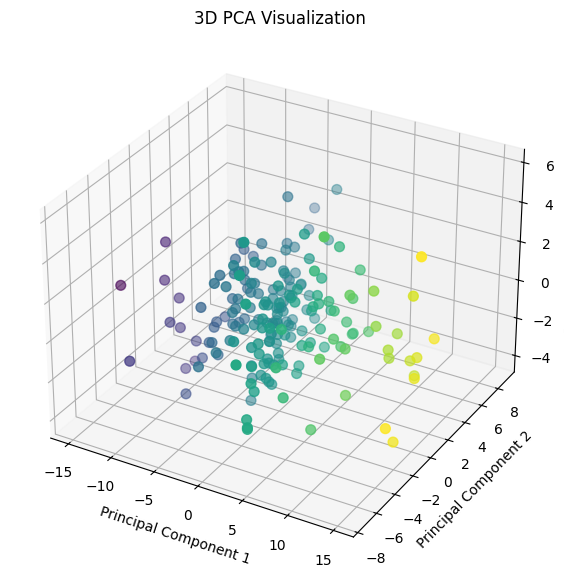

In [34]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(filtered_train.fillna(filtered_train.median()))

pca = PCA(n_components=3)
pca_res = pca.fit_transform(df_scaled)

df_pca = pd.DataFrame(pca_res, columns=['PC1', 'PC2', 'PC3'])

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'], c=df_pca['PC1'], cmap='viridis', s=50)

ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.set_title("3D PCA Visualization")

plt.show()

- PC1 (X-axis) likely captures the most dominant trend in height variations across different ages.
- PC2 (Y-axis) might capture secondary trends, such as gender differences or early vs. late growth spurts.
- PC3 (Z-axis) might capture non-linear variations, such as individuals with unusual growth patterns.

Tightly clustered points in the center → Represents individuals with average height progression.

Points further apart (outliers) → Represents individuals with atypical growth patterns, possible outliers in height distribution.

### Handle missing values
Starting from here, we will split train data into train, validation and test set to avoid data leakage.

`optim1: add test set to test on model's generalization`

In [33]:
# split into train and validation set
x_train, x_test, y_train, y_test = train_test_split(filtered_train, Y_train, test_size=0.2, random_state=13)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=13)
x_train.shape, y_train.shape, x_val.shape, x_test.shape

((122, 53), (122, 8), (31, 53), (39, 53))

Impute numerical columns first

In [34]:
# get numerical columns for x_train
x_train_num = x_train.drop(columns=['gen1_gender'])
x_train_num

,gen2_gender,gen2_hgt_0.1,gen2_hgt_0.25,gen2_hgt_0.5,gen2_hgt_0.75,gen2_hgt_1.0,gen2_hgt_1.5,gen2_hgt_2.0,gen2_hgt_3.0,gen2_hgt_4.0,...,gen1_hgt_14.0,gen1_hgt_14.5,gen1_hgt_15.0,gen1_hgt_15.5,gen1_hgt_16.0,gen1_hgt_16.5,gen1_hgt_17.0,gen1_hgt_18.0,gen1_hgt_19.0,gen1_hgt_20.0
gen2_id,,,,,,,,,,,,,,,,,,,,,
2532,1,56.590928,63.363593,69.538656,73.596947,78.050194,84.397421,90.502953,99.069951,NaN,...,148.539511,151.630686,156.009695,160.282364,162.509524,164.923176,166.224135,168.235029,168.293295,169.311332
2599,1,54.293434,59.277426,67.054067,72.422537,76.474723,83.243615,90.031757,NaN,104.894286,...,169.145390,170.117640,171.064237,171.450506,172.261825,172.379268,172.646257,172.200890,172.075126,173.100697
2620,1,53.773120,59.750982,66.410591,70.985451,77.280121,83.166223,92.652784,102.257995,109.879521,...,160.400675,161.568117,162.046895,161.696806,162.446983,162.614476,163.167202,163.063660,162.802728,162.602366
2753,1,NaN,NaN,NaN,72.914076,NaN,NaN,94.597009,NaN,NaN,...,163.773023,165.308165,164.701812,164.864807,165.135485,NaN,165.274498,165.684804,164.937741,165.219967
2624,1,57.198105,62.651932,69.884751,72.452064,79.005851,87.953643,93.802552,NaN,110.657969,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2560,0,NaN,65.387719,69.779022,74.360297,78.436437,85.724588,90.819076,NaN,106.560180,...,168.922651,169.165416,169.263186,169.652612,170.166647,170.572678,170.574775,170.210158,170.781698,171.460289
2654,1,58.133472,62.679087,68.784790,73.971819,78.911330,86.233948,91.278234,101.620060,NaN,...,165.806085,166.767275,167.359000,167.229044,167.138275,NaN,168.413633,168.351274,168.475318,168.045952
2767,1,56.578735,62.050310,68.261566,72.683350,77.750490,84.811876,92.867057,102.731116,109.664110,...,163.350099,165.111793,167.228398,168.335543,168.616880,170.150819,170.605831,171.022288,171.196926,170.803340


`optim3: reduce n_neighbors to 2`

In [35]:
# impute missing values for numerical columns
knn_imputer = KNNImputer(n_neighbors=2)
knn_imputer.fit(x_train_num)
x_train_num_imputed = knn_imputer.transform(x_train_num)

In [36]:
# convert from np array to df
x_train_num_imputed_df = pd.DataFrame(x_train_num_imputed, columns=x_train_num.columns)
x_train_num_imputed_df.set_index(x_train.index, inplace=True)
x_train_num_imputed_df

,gen2_gender,gen2_hgt_0.1,gen2_hgt_0.25,gen2_hgt_0.5,gen2_hgt_0.75,gen2_hgt_1.0,gen2_hgt_1.5,gen2_hgt_2.0,gen2_hgt_3.0,gen2_hgt_4.0,...,gen1_hgt_14.0,gen1_hgt_14.5,gen1_hgt_15.0,gen1_hgt_15.5,gen1_hgt_16.0,gen1_hgt_16.5,gen1_hgt_17.0,gen1_hgt_18.0,gen1_hgt_19.0,gen1_hgt_20.0
gen2_id,,,,,,,,,,,,,,,,,,,,,
2532,1.0,56.590928,63.363593,69.538656,73.596947,78.050194,84.397421,90.502953,99.069951,103.867969,...,148.539511,151.630686,156.009695,160.282364,162.509524,164.923176,166.224135,168.235029,168.293295,169.311332
2599,1.0,54.293434,59.277426,67.054067,72.422537,76.474723,83.243615,90.031757,98.856418,104.894286,...,169.145390,170.117640,171.064237,171.450506,172.261825,172.379268,172.646257,172.200890,172.075126,173.100697
2620,1.0,53.773120,59.750982,66.410591,70.985451,77.280121,83.166223,92.652784,102.257995,109.879521,...,160.400675,161.568117,162.046895,161.696806,162.446983,162.614476,163.167202,163.063660,162.802728,162.602366
2753,1.0,57.058906,63.105597,69.465993,72.914076,78.080386,87.690345,94.597009,105.928053,111.406200,...,163.773023,165.308165,164.701812,164.864807,165.135485,167.096911,165.274498,165.684804,164.937741,165.219967
2624,1.0,57.198105,62.651932,69.884751,72.452064,79.005851,87.953643,93.802552,103.413143,110.657969,...,169.814310,171.424682,171.441594,171.822627,172.161602,185.581822,172.617978,172.657458,172.485972,172.513464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2560,0.0,58.107664,65.387719,69.779022,74.360297,78.436437,85.724588,90.819076,98.415168,106.560180,...,168.922651,169.165416,169.263186,169.652612,170.166647,170.572678,170.574775,170.210158,170.781698,171.460289
2654,1.0,58.133472,62.679087,68.784790,73.971819,78.911330,86.233948,91.278234,101.620060,104.812435,...,165.806085,166.767275,167.359000,167.229044,167.138275,171.475973,168.413633,168.351274,168.475318,168.045952
2767,1.0,56.578735,62.050310,68.261566,72.683350,77.750490,84.811876,92.867057,102.731116,109.664110,...,163.350099,165.111793,167.228398,168.335543,168.616880,170.150819,170.605831,171.022288,171.196926,170.803340


In [37]:
# add gender column back
x_train_concat = pd.concat([x_train_num_imputed_df, x_train[['gen1_gender']]], axis=1)
x_train_concat

,gen2_gender,gen2_hgt_0.1,gen2_hgt_0.25,gen2_hgt_0.5,gen2_hgt_0.75,gen2_hgt_1.0,gen2_hgt_1.5,gen2_hgt_2.0,gen2_hgt_3.0,gen2_hgt_4.0,...,gen1_hgt_14.5,gen1_hgt_15.0,gen1_hgt_15.5,gen1_hgt_16.0,gen1_hgt_16.5,gen1_hgt_17.0,gen1_hgt_18.0,gen1_hgt_19.0,gen1_hgt_20.0,gen1_gender
gen2_id,,,,,,,,,,,,,,,,,,,,,
2532,1.0,56.590928,63.363593,69.538656,73.596947,78.050194,84.397421,90.502953,99.069951,103.867969,...,151.630686,156.009695,160.282364,162.509524,164.923176,166.224135,168.235029,168.293295,169.311332,1.0
2599,1.0,54.293434,59.277426,67.054067,72.422537,76.474723,83.243615,90.031757,98.856418,104.894286,...,170.117640,171.064237,171.450506,172.261825,172.379268,172.646257,172.200890,172.075126,173.100697,0.0
2620,1.0,53.773120,59.750982,66.410591,70.985451,77.280121,83.166223,92.652784,102.257995,109.879521,...,161.568117,162.046895,161.696806,162.446983,162.614476,163.167202,163.063660,162.802728,162.602366,0.0
2753,1.0,57.058906,63.105597,69.465993,72.914076,78.080386,87.690345,94.597009,105.928053,111.406200,...,165.308165,164.701812,164.864807,165.135485,167.096911,165.274498,165.684804,164.937741,165.219967,0.0
2624,1.0,57.198105,62.651932,69.884751,72.452064,79.005851,87.953643,93.802552,103.413143,110.657969,...,171.424682,171.441594,171.822627,172.161602,185.581822,172.617978,172.657458,172.485972,172.513464,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2560,0.0,58.107664,65.387719,69.779022,74.360297,78.436437,85.724588,90.819076,98.415168,106.560180,...,169.165416,169.263186,169.652612,170.166647,170.572678,170.574775,170.210158,170.781698,171.460289,0.0
2654,1.0,58.133472,62.679087,68.784790,73.971819,78.911330,86.233948,91.278234,101.620060,104.812435,...,166.767275,167.359000,167.229044,167.138275,171.475973,168.413633,168.351274,168.475318,168.045952,0.0
2767,1.0,56.578735,62.050310,68.261566,72.683350,77.750490,84.811876,92.867057,102.731116,109.664110,...,165.111793,167.228398,168.335543,168.616880,170.150819,170.605831,171.022288,171.196926,170.803340,0.0


Now, impute categorical column

In [38]:
# fill missing values for gen1_gender in x_train
x_train_gender_filled = x_train_concat.copy()

train_gender = x_train_gender_filled[x_train_gender_filled['gen1_gender'].notna()]
test_gender = x_train_gender_filled[x_train_gender_filled['gen1_gender'].isna()]

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(train_gender.loc[:, 'gen1_hgt_0.1':'gen1_hgt_20.0'], train_gender['gen1_gender'])

x_train_gender_filled.loc[x_train_gender_filled['gen1_gender'].isna(), 'gen1_gender'] = knn.predict(test_gender.loc[:, 'gen1_hgt_0.1':'gen1_hgt_20.0'])

In [39]:
# the distribution after imputation looks fine
x_train_gender_filled['gen1_gender'].value_counts(), x_train['gen1_gender'].value_counts()

(gen1_gender
 0.0    62
 1.0    60
 Name: count, dtype: int64,
 gen1_gender
 1.0    51
 0.0    42
 Name: count, dtype: int64)

Use the same imputer and classifier on val, test, inference set

In [40]:
# impute numerical columns first
x_val_num = x_val.drop(columns=['gen1_gender'])
x_val_num_imputed = knn_imputer.transform(x_val_num)

x_val_num_imputed_df = pd.DataFrame(x_val_num_imputed, columns=x_val_num.columns)
x_val_num_imputed_df.set_index(x_val.index, inplace=True)

x_val_concat = pd.concat([x_val_num_imputed_df, x_val[['gen1_gender']]], axis=1)

# then impute categorical column
x_val_gender_filled = x_val_concat.copy()

test_gender_val = x_val_gender_filled[x_val_gender_filled['gen1_gender'].isna()]

x_val_gender_filled.loc[x_val_gender_filled['gen1_gender'].isna(), 'gen1_gender'] = knn.predict(test_gender_val.loc[:, 'gen1_hgt_0.1':'gen1_hgt_20.0'])

x_val_gender_filled['gen1_gender'].value_counts(), x_val['gen1_gender'].value_counts()

(gen1_gender
 0.0    18
 1.0    13
 Name: count, dtype: int64,
 gen1_gender
 0.0    15
 1.0    10
 Name: count, dtype: int64)

In [41]:
# impute numerical columns first
x_test_num = x_test.drop(columns=['gen1_gender'])
x_test_num_imputed = knn_imputer.transform(x_test_num)

x_test_num_imputed_df = pd.DataFrame(x_test_num_imputed, columns=x_test_num.columns)
x_test_num_imputed_df.set_index(x_test.index, inplace=True)

x_test_concat = pd.concat([x_test_num_imputed_df, x_test[['gen1_gender']]], axis=1)

# then impute categorical column
x_test_gender_filled = x_test_concat.copy()

test_gender_test = x_test_gender_filled[x_test_gender_filled['gen1_gender'].isna()]

x_test_gender_filled.loc[x_test_gender_filled['gen1_gender'].isna(), 'gen1_gender'] = knn.predict(test_gender_test.loc[:, 'gen1_hgt_0.1':'gen1_hgt_20.0'])

x_test_gender_filled['gen1_gender'].value_counts(), x_test['gen1_gender'].value_counts()

(gen1_gender
 0.0    20
 1.0    19
 Name: count, dtype: int64,
 gen1_gender
 1.0    17
 0.0    16
 Name: count, dtype: int64)

In [42]:
# impute numerical columns first
test_num = merged_test.drop(columns=['gen1_gender'])

test_num_imputed = knn_imputer.transform(test_num)

test_num_imputed_df = pd.DataFrame(test_num_imputed, columns=test_num.columns)
test_num_imputed_df.set_index(merged_test.index, inplace=True)

test_concat = pd.concat([test_num_imputed_df, merged_test[['gen1_gender']]], axis=1)

# then impute categorical column
test_gender_filled = test_concat.copy()

test_gender_inf = test_gender_filled[test_gender_filled['gen1_gender'].isna()]

test_gender_filled.loc[test_gender_filled['gen1_gender'].isna(), 'gen1_gender'] = knn.predict(test_gender_inf.loc[:, 'gen1_hgt_0.1':'gen1_hgt_20.0'])

test_gender_filled['gen1_gender'].value_counts(), merged_test['gen1_gender'].value_counts()

(gen1_gender
 0.0    50
 1.0    38
 Name: count, dtype: int64,
 gen1_gender
 0.0    41
 1.0    28
 Name: count, dtype: int64)

Impute target variables

target variables don't have gender(categorical) column, so we only need to impute numerical columns

In [43]:
knn_imputer_y = KNNImputer(n_neighbors=3) # we use a different imputer for target variables
knn_imputer_y.fit(y_train) # fit on train set

y_train_imputed = knn_imputer_y.transform(y_train) # impute on train set
y_val_imputed = knn_imputer_y.transform(y_val) # impute on validation set
y_test_imputed = knn_imputer_y.transform(y_test) # impute on test set

y_train_imputed_df = pd.DataFrame(y_train_imputed, columns=y_train.columns) # convert to df
y_train_imputed_df.set_index(y_train.index, inplace=True) # set index to gen2_id

y_val_imputed_df = pd.DataFrame(y_val_imputed, columns=y_val.columns) # convert to df
y_val_imputed_df.set_index(y_val.index, inplace=True) # set index to gen2_id

y_test_imputed_df = pd.DataFrame(y_test_imputed, columns=y_test.columns) # convert to df
y_test_imputed_df.set_index(y_test.index, inplace=True) # set index to gen2_id

y_train_imputed_df.isna().sum(), y_val_imputed_df.isna().sum(), y_test_imputed_df.isna().sum() # no missing values now

(gen2_hgt_10.0    0
 gen2_hgt_11.0    0
 gen2_hgt_12.0    0
 gen2_hgt_13.0    0
 gen2_hgt_14.0    0
 gen2_hgt_15.0    0
 gen2_hgt_16.0    0
 gen2_hgt_18.0    0
 dtype: int64,
 gen2_hgt_10.0    0
 gen2_hgt_11.0    0
 gen2_hgt_12.0    0
 gen2_hgt_13.0    0
 gen2_hgt_14.0    0
 gen2_hgt_15.0    0
 gen2_hgt_16.0    0
 gen2_hgt_18.0    0
 dtype: int64,
 gen2_hgt_10.0    0
 gen2_hgt_11.0    0
 gen2_hgt_12.0    0
 gen2_hgt_13.0    0
 gen2_hgt_14.0    0
 gen2_hgt_15.0    0
 gen2_hgt_16.0    0
 gen2_hgt_18.0    0
 dtype: int64)

`optim2: update hyperparame's tuning range to avoid overfitting`

`optim3: remove sequential modeling and use multi-output regressor`

### Fit model

In [44]:
# 1. Tune and Train XGBoost 
def objective_xgb(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 6), # Reduced from 3-10
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500), # Reduced from 100-1000
        'gamma': trial.suggest_float('gamma', 0, 3),
        'reg_alpha': trial.suggest_float('reg_alpha', 1, 15), # Increased regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 5, 25) # Increased regularization
    }
    model = MultiOutputRegressor(XGBRegressor(**params, objective='reg:squarederror', eval_metric='mae', random_state=13))
    scores = cross_val_score(model, x_train_gender_filled, y_train_imputed_df,
                                scoring='neg_mean_absolute_error', cv=5, n_jobs=-1) # increase cv from 3
    return -np.mean(scores)
    
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=15) # reduce n_trials from 30 
best_params_xgb = study_xgb.best_trial.params

xgb_model = MultiOutputRegressor(XGBRegressor(**best_params_xgb, objective='reg:squarederror', eval_metric='mae', random_state=13))
xgb_model.fit(x_train_gender_filled, y_train_imputed_df)
    
# 2. Tune and Train LightGBM 
def objective_lgb(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 6), # Reduced from 3-10
        'num_leaves': trial.suggest_int('num_leaves', 20, 80), # Reduced from 32-100
        'n_estimators': trial.suggest_int('n_estimators', 50, 500), # Reduced from 100-1000
        'subsample': trial.suggest_float('subsample', 0.6, 0.9), # Reduced from 0.8-1.0
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9), # Reduced from 0.8-1.0
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 10), # Add regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10) # Add regularization
    }
    model = MultiOutputRegressor(lgb.LGBMRegressor(**params, random_state=13, verbose=-1))
    scores = cross_val_score(model, x_train_gender_filled, y_train_imputed_df,
                                scoring='neg_mean_absolute_error', cv=5, n_jobs=-1) # increase cv from 3
    return -np.mean(scores)

study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective_lgb, n_trials=15) # reduce n_trials from 30 
best_params_lgb = study_lgb.best_trial.params

lgb_model = MultiOutputRegressor(lgb.LGBMRegressor(**best_params_lgb, random_state=13, verbose=-1))
lgb_model.fit(x_train_gender_filled, y_train_imputed_df)
    
# 3. Tune and Train RandomForest 
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500), # Reduced from 100-1000
        'max_depth': trial.suggest_int('max_depth', 2, 8), # Reduced from 3-15
        'min_samples_split': trial.suggest_int('min_samples_split', 3, 12), # increased from 2-10
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 6) # increased from 1-4
    }
    model = MultiOutputRegressor(RandomForestRegressor(**params, random_state=13))
    scores = cross_val_score(model, x_train_gender_filled, y_train_imputed_df,
                                scoring='neg_mean_absolute_error', cv=5, n_jobs=-1) # increase cv from 3
    return -np.mean(scores)

study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=15) # reduce n_trials from 30 
best_params_rf = study_rf.best_trial.params

rf_model = MultiOutputRegressor(RandomForestRegressor(**best_params_rf, random_state=13))
rf_model.fit(x_train_gender_filled, y_train_imputed_df)
    
# Ensemble the Predictions 
pred_xgb = xgb_model.predict(x_val_gender_filled)
pred_lgb = lgb_model.predict(x_val_gender_filled)
pred_rf = rf_model.predict(x_val_gender_filled)

# take simple average of predictions
ensemble_pred = (pred_xgb + pred_lgb + pred_rf) / 3.0

# Evaluate the sequential ensemble predictions per target
mae_val = mean_absolute_error(y_val_imputed_df, ensemble_pred)
rmse_val = np.sqrt(mean_squared_error(y_val_imputed_df, ensemble_pred))
r2_val = r2_score(y_val_imputed_df, ensemble_pred)

validation score

In [45]:
print(f"\nMAE: {mae_val:.4f}")
print(f"RMSE: {rmse_val:.4f}")
print(f"R2: {r2_val:.4f}")


MAE: 3.0949
RMSE: 3.9309
R2: 0.5114


test score

In [46]:
pred_xgb_test = xgb_model.predict(x_test_gender_filled)
pred_lgb_test = lgb_model.predict(x_test_gender_filled)
pred_rf_test = rf_model.predict(x_test_gender_filled)

ensemble_pred_test = (pred_xgb_test + pred_lgb_test + pred_rf_test) / 3.0

mae_test = mean_absolute_error(y_test_imputed_df, ensemble_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test_imputed_df, ensemble_pred_test))
r2_test = r2_score(y_test_imputed_df, ensemble_pred_test)

print(f"\nMAE: {mae_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"R2: {r2_test:.4f}")


MAE: 3.4192
RMSE: 4.3610
R2: 0.5581


Use all the data to train the best model

In [47]:
x_full = pd.concat([x_train_gender_filled, x_val_gender_filled, x_test_gender_filled])
y_full = pd.concat([y_train_imputed_df, y_val_imputed_df, y_test_imputed_df])

xgb_model_full = MultiOutputRegressor(XGBRegressor(**best_params_xgb, objective='reg:squarederror', eval_metric='mae', random_state=13))
xgb_model_full.fit(x_full, y_full)

lgb_model_full = MultiOutputRegressor(lgb.LGBMRegressor(**best_params_lgb, random_state=13, verbose=-1))
lgb_model_full.fit(x_full, y_full)

rf_model_full = MultiOutputRegressor(RandomForestRegressor(**best_params_rf, random_state=13))
rf_model_full.fit(x_full, y_full)

MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=4,
                                                     min_samples_leaf=3,
                                                     min_samples_split=5,
                                                     n_estimators=51,
                                                     random_state=13))

In [48]:
pred_xgb_final = xgb_model_full.predict(test_gender_filled)
pred_lgb_final = lgb_model_full.predict(test_gender_filled)
pred_rf_final = rf_model_full.predict(test_gender_filled)

ensemble_pred_final = (pred_xgb_final + pred_lgb_final + pred_rf_final) / 3.0

### Prepare for output

In [51]:
# np.array to dataframe
df = pd.DataFrame(ensemble_pred_final, columns=y_cols)
df.set_index(merged_test.index, inplace=True)
df

,gen2_hgt_10.0,gen2_hgt_11.0,gen2_hgt_12.0,gen2_hgt_13.0,gen2_hgt_14.0,gen2_hgt_15.0,gen2_hgt_16.0,gen2_hgt_18.0
gen2_id,,,,,,,,
2332,132.358619,138.154181,143.967289,149.464916,155.283826,160.416412,164.672593,168.958910
2503,146.463036,152.390887,160.405860,165.691735,170.013676,171.179478,172.911089,173.780808
2504,134.298363,140.032610,146.952832,153.199590,158.815642,162.483792,165.399284,167.391735
2506,144.804020,151.683511,158.272820,164.499401,169.163406,171.257233,173.220316,174.284940
2508,148.217029,155.296915,162.266652,167.220010,172.366260,172.297841,175.624588,177.382515
...,...,...,...,...,...,...,...,...
2820,136.365493,142.788252,147.387935,153.031377,159.168971,163.614200,169.595420,174.369630
2821,147.480448,155.226746,161.464251,165.387861,167.525286,168.659488,170.515024,171.522721
2822,142.108951,147.384780,153.175765,160.364967,166.994261,172.829947,176.176808,178.463538


In [53]:
# check the required format
template = pd.read_csv('../final_proj/gen2_test_solution_template.csv')
template

,gen2id_age,SHgt_cm
0,2831_10,150
1,2831_11,150
2,2831_12,150
3,2831_13,150
4,2831_14,150
...,...,...
584,2332_11,150
585,2332_12,150
586,2332_13,150
587,2332_14,150


In [54]:
# format template to align with my df
template[['gen2_id', 'age']] = template['gen2id_age'].str.split('_', expand=True)
template = template[['gen2_id', 'age', 'SHgt_cm']]
template.sort_values(by='gen2_id', inplace=True, ascending=False)
template_wide = template.pivot(index='gen2_id', columns='age', values='SHgt_cm')
template_wide.columns.name = None
template_wide.index = template_wide.index.astype(int)
template_wide

,10,11,12,13,14,15,16,18
gen2_id,,,,,,,,
2332,NaN,150.0,150.0,150.0,150.0,150.0,NaN,NaN
2503,150.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2504,150.0,NaN,150.0,NaN,NaN,NaN,NaN,NaN
2506,150.0,150.0,150.0,NaN,NaN,NaN,NaN,NaN
2508,150.0,150.0,150.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2820,150.0,150.0,150.0,150.0,150.0,150.0,150.0,150.0
2821,150.0,150.0,150.0,150.0,150.0,150.0,150.0,150.0
2822,150.0,150.0,150.0,150.0,150.0,150.0,150.0,150.0


In [55]:
# change the column names of my predictions to match template
df.columns = template_wide.columns
df

,10,11,12,13,14,15,16,18
gen2_id,,,,,,,,
2332,132.358619,138.154181,143.967289,149.464916,155.283826,160.416412,164.672593,168.958910
2503,146.463036,152.390887,160.405860,165.691735,170.013676,171.179478,172.911089,173.780808
2504,134.298363,140.032610,146.952832,153.199590,158.815642,162.483792,165.399284,167.391735
2506,144.804020,151.683511,158.272820,164.499401,169.163406,171.257233,173.220316,174.284940
2508,148.217029,155.296915,162.266652,167.220010,172.366260,172.297841,175.624588,177.382515
...,...,...,...,...,...,...,...,...
2820,136.365493,142.788252,147.387935,153.031377,159.168971,163.614200,169.595420,174.369630
2821,147.480448,155.226746,161.464251,165.387861,167.525286,168.659488,170.515024,171.522721
2822,142.108951,147.384780,153.175765,160.364967,166.994261,172.829947,176.176808,178.463538


In [56]:
# update the template with the predictions
temp_updated = template_wide.where(template_wide.isna(), df)

In [57]:
temp_updated

,10,11,12,13,14,15,16,18
gen2_id,,,,,,,,
2332,NaN,138.154181,143.967289,149.464916,155.283826,160.416412,NaN,NaN
2503,146.463036,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2504,134.298363,NaN,146.952832,NaN,NaN,NaN,NaN,NaN
2506,144.804020,151.683511,158.272820,NaN,NaN,NaN,NaN,NaN
2508,148.217029,155.296915,162.266652,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2820,136.365493,142.788252,147.387935,153.031377,159.168971,163.614200,169.595420,174.369630
2821,147.480448,155.226746,161.464251,165.387861,167.525286,168.659488,170.515024,171.522721
2822,142.108951,147.384780,153.175765,160.364967,166.994261,172.829947,176.176808,178.463538


In [58]:
# reformat the template back to its original format
temp_updated = temp_updated.reset_index()
temp_long = temp_updated.melt(id_vars=['gen2_id'], var_name='age', value_name='SHgt_cm')

In [59]:
temp_long

,gen2_id,age,SHgt_cm
0,2332,10,NaN
1,2503,10,146.463036
2,2504,10,134.298363
3,2506,10,144.804020
4,2508,10,148.217029
...,...,...,...
651,2820,18,174.369630
652,2821,18,171.522721
653,2822,18,178.463538
654,2823,18,177.069946


In [60]:
# sort by gen2_id and age
temp_long_sorted = temp_long.sort_values(by=['gen2_id', 'age'], ascending=[False, True])

In [61]:
temp_long_sorted

,gen2_id,age,SHgt_cm
81,2831,10,138.938900
163,2831,11,144.964445
245,2831,12,151.391468
327,2831,13,156.010060
409,2831,14,160.683879
...,...,...,...
246,2332,13,149.464916
328,2332,14,155.283826
410,2332,15,160.416412
492,2332,16,NaN


In [62]:
temp_clean = temp_long_sorted.dropna()

In [63]:
temp_clean

,gen2_id,age,SHgt_cm
81,2831,10,138.938900
163,2831,11,144.964445
245,2831,12,151.391468
327,2831,13,156.010060
409,2831,14,160.683879
...,...,...,...
82,2332,11,138.154181
164,2332,12,143.967289
246,2332,13,149.464916
328,2332,14,155.283826


In [64]:
temp_clean['gen2id_age'] = temp_clean['gen2_id'].astype(str) + '_' + temp_clean['age'].astype(str)

In [65]:
temp_clean

,gen2_id,age,SHgt_cm,gen2id_age
81,2831,10,138.938900,2831_10
163,2831,11,144.964445,2831_11
245,2831,12,151.391468,2831_12
327,2831,13,156.010060,2831_13
409,2831,14,160.683879,2831_14
...,...,...,...,...
82,2332,11,138.154181,2332_11
164,2332,12,143.967289,2332_12
246,2332,13,149.464916,2332_13
328,2332,14,155.283826,2332_14


In [66]:
# select the required columns
temp_final = temp_clean[['gen2id_age', 'SHgt_cm']]

In [67]:
temp_final

,gen2id_age,SHgt_cm
81,2831_10,138.938900
163,2831_11,144.964445
245,2831_12,151.391468
327,2831_13,156.010060
409,2831_14,160.683879
...,...,...
82,2332_11,138.154181
164,2332_12,143.967289
246,2332_13,149.464916
328,2332_14,155.283826


In [68]:
out = temp_final.reset_index(drop=True)

In [69]:
out

,gen2id_age,SHgt_cm
0,2831_10,138.938900
1,2831_11,144.964445
2,2831_12,151.391468
3,2831_13,156.010060
4,2831_14,160.683879
...,...,...
584,2332_11,138.154181
585,2332_12,143.967289
586,2332_13,149.464916
587,2332_14,155.283826


In [70]:
# out.to_csv('solution11.csv', index=False)